In [2]:
import os, glob
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [3]:
imagePathInput = r'N:\2_Analysis\automated_analysis\00_2D_UNET_FRAMEWORK\Binary\Spleen Segmentation\3D_NII_IMAGES\LIG_SPLEEN_IDEAL\LIG_IDEAL_IMAGE/'
maskPathInput = r'N:\2_Analysis\automated_analysis\00_2D_UNET_FRAMEWORK\Binary\Spleen Segmentation\3D_NII_IMAGES\LIG_SPLEEN_IDEAL\LIG_IDEAL_MASK/'

imageSliceOutput = r'N:\2_Analysis\automated_analysis\00_2D_UNET_FRAMEWORK\Binary\Spleen Segmentation\2D_PNG_IMAGES\LIG_IDEAL\train\image\image/'
maskSliceOutput = r'N:\2_Analysis\automated_analysis\00_2D_UNET_FRAMEWORK\Binary\Spleen Segmentation\2D_PNG_IMAGES\LIG_IDEAL\train\mask\mask/'

IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256

In [4]:
print(imagePathInput)
print(maskPathInput)

print(imageSliceOutput)
print(maskSliceOutput)

N:\2_Analysis\automated_analysis\00_2D_UNET_FRAMEWORK\Binary\Spleen Segmentation\3D_NII_IMAGES\LIG_SPLEEN_IDEAL\LIG_IDEAL_IMAGE/
N:\2_Analysis\automated_analysis\00_2D_UNET_FRAMEWORK\Binary\Spleen Segmentation\3D_NII_IMAGES\LIG_SPLEEN_IDEAL\LIG_IDEAL_MASK/
N:\2_Analysis\automated_analysis\00_2D_UNET_FRAMEWORK\Binary\Spleen Segmentation\2D_PNG_IMAGES\LIG_IDEAL\train\image\image/
N:\2_Analysis\automated_analysis\00_2D_UNET_FRAMEWORK\Binary\Spleen Segmentation\2D_PNG_IMAGES\LIG_IDEAL\train\mask\mask/


In [37]:
imgPath = os.path.join(imagePathInput, 'SHS36045.nii')
img = nib.load(imgPath).get_fdata()
print(np.min(img), np.max(img), img.shape, type(img))
print(imgPath)

0.0 4823.0 (256, 256, 36) <class 'numpy.memmap'>
N:\2_Analysis\automated_analysis\00_2D_UNET_FRAMEWORK\Binary\Spleen Segmentation\3D_NII_IMAGES\LIG_SPLEEN_IDEAL\LIG_IDEAL_IMAGE/SHS36045.nii


In [65]:
maskPath = os.path.join(maskPathInput, 'SHS36045.nii')
mask = nib.load(maskPath).get_fdata()
np.min(mask), np.max(mask), mask.shape, type(mask)

(0.0, 1.0, (256, 256, 36), numpy.memmap)

In [66]:
def scaleImg(img, height, width):
    return cv2.resize(img, dsize=(width, height), interpolation=cv2.INTER_LINEAR)

In [67]:
img = scaleImg(img, IMAGE_HEIGHT, IMAGE_WIDTH)
mask = scaleImg(mask, IMAGE_HEIGHT, IMAGE_WIDTH)

In [68]:
np.min(img), np.max(img), img.shape, type(img)

(0.0, 4823.0, (256, 256, 36), numpy.ndarray)

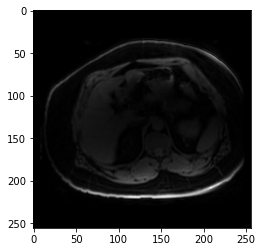

In [69]:
#imgSlice = np.flip((np.rot90(img[:,:,12])), 1)
imgSlice = np.flip(np.rot90(img[:,:,18]), 0)
plt.imshow(imgSlice, cmap='gray')
plt.show()

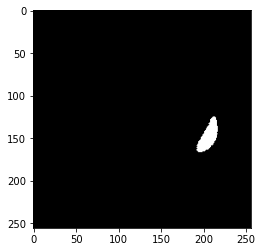

In [70]:
maskSlice = np.flip((np.rot90(mask[:,:,18])), 0)
plt.imshow(maskSlice, cmap='gray')
plt.show()

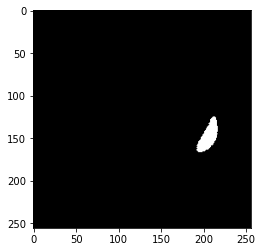

In [71]:
# RUN THIS TO GET ONLY BINARY CLASSIFICATION

spleen = maskSlice
spleen[maskSlice == 1] = 2
spleen[maskSlice != 2] = 0
plt.imshow(spleen, cmap='gray')
plt.show()

In [72]:
# Normalize image
def normalizeImageIntensityRange(img):
    HOUNSFIELD_MIN = np.min(img)
    HOUNSFIELD_MAX = np.max(img)
    HOUNSFIELD_RANGE = HOUNSFIELD_MAX - HOUNSFIELD_MIN
    
    img[img < HOUNSFIELD_MIN] = HOUNSFIELD_MIN
    img[img > HOUNSFIELD_MAX] = HOUNSFIELD_MAX
    return ((img - HOUNSFIELD_MIN) / HOUNSFIELD_RANGE)

In [73]:
nImg = normalizeImageIntensityRange(img)
nImg15 = np.flip((np.rot90(nImg[:,:,12])), 0)
np.min(nImg), np.max(nImg), nImg.shape, type(nImg)

(0.0, 1.0, (256, 256, 36), numpy.ndarray)

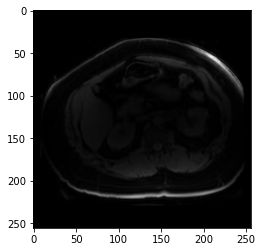

In [74]:
plt.imshow(nImg15, cmap = 'gray')
plt.show()

In [75]:
def readImageVolume(imgPath, normalize=False):
    img = nib.load(imgPath).get_fdata()
    if normalize:
        return normalizeImageIntensityRange(img)
    else:
        return img

In [76]:
# RUN THIS FOR BINARY CLASSIFICATION

def readImageVolume1(imgPath, normalize=False):
    img = nib.load(imgPath).get_fdata()
    spleen = img
    spleen[img == 1] = 2
    spleen[img != 2] = 0
    if normalize:
        return normalizeImageIntensityRange(img)
    else:
        return img

In [77]:
def saveSlice(img, fname, path):
    img = np.flip((np.rot90(np.uint8(img * 255))), 0)
    fout = os.path.join(path, f'{fname}.png')
    cv2.imwrite(fout, img)
    print(f'[+] Slice saved: {fout}', end='\r')

In [78]:
def sliceAndSaveVolumeImage(vol, fname, path):
    (dimx, dimy, dimz) = vol.shape
    print(dimx, dimy, dimz)
    cnt = 0
    print('Slicing Z: ')
    for i in range(dimz):
        cnt += 1
        saveSlice(vol[:,:,i], fname+f'-slice{str(i).zfill(3)}_z', path)
    return cnt

In [79]:
# FIND HOW MANY IMAGES ARE ACTUALLY BEING SLICED
cnt = 0
for index, filename in enumerate(sorted(glob.iglob(imagePathInput+'*.nii'))):
    cnt += 1
print(cnt)

20


In [80]:
# Read and process image volumes
for index, filename in enumerate(sorted(glob.iglob(imagePathInput+'*.nii'))):
    print('Slicing number ' + str(index))
    img = readImageVolume(filename, True)
    print(filename, img.shape, np.min(img), np.max(img))
    numOfSlices = sliceAndSaveVolumeImage(img, 'image'+str(index+1), imageSliceOutput)
    print(f'\n{filename}, {numOfSlices} slices created \n')

Slicing number 0
N:\2_Analysis\automated_analysis\00_2D_UNET_FRAMEWORK\Binary\Spleen Segmentation\3D_NII_IMAGES\LIG_SPLEEN_IDEAL\LIG_IDEAL_IMAGE\A003.nii (256, 256, 24) 0.0 1.0
256 256 24
Slicing Z: 
[+] Slice saved: N:\2_Analysis\automated_analysis\00_2D_UNET_FRAMEWORK\Binary\Spleen Segmentation\2D_PNG_IMAGES\LIG_IDEAL\train\image\image/image1-slice023_z.png
N:\2_Analysis\automated_analysis\00_2D_UNET_FRAMEWORK\Binary\Spleen Segmentation\3D_NII_IMAGES\LIG_SPLEEN_IDEAL\LIG_IDEAL_IMAGE\A003.nii, 24 slices created 

Slicing number 1
N:\2_Analysis\automated_analysis\00_2D_UNET_FRAMEWORK\Binary\Spleen Segmentation\3D_NII_IMAGES\LIG_SPLEEN_IDEAL\LIG_IDEAL_IMAGE\A004.nii (256, 256, 24) 0.0 1.0
256 256 24
Slicing Z: 
[+] Slice saved: N:\2_Analysis\automated_analysis\00_2D_UNET_FRAMEWORK\Binary\Spleen Segmentation\2D_PNG_IMAGES\LIG_IDEAL\train\image\image/image2-slice023_z.png
N:\2_Analysis\automated_analysis\00_2D_UNET_FRAMEWORK\Binary\Spleen Segmentation\3D_NII_IMAGES\LIG_SPLEEN_IDEAL\LIG_ID

In [81]:
# Read and process image volumes
for index, filename in enumerate(sorted(glob.iglob(maskPathInput+'*.nii'))):
    print('Slicing number ' + str(index))
    img = readImageVolume1(filename, False)
    print(filename, img.shape, np.min(img), np.max(img))
    numOfSlices = sliceAndSaveVolumeImage(img, 'mask'+str(index+1), maskSliceOutput)
    print(f'\n{filename}, {numOfSlices} slices created \n')

Slicing number 0
N:\2_Analysis\automated_analysis\00_2D_UNET_FRAMEWORK\Binary\Spleen Segmentation\3D_NII_IMAGES\LIG_SPLEEN_IDEAL\LIG_IDEAL_MASK\A003.nii (256, 256, 24) 0.0 2.0
256 256 24
Slicing Z: 
[+] Slice saved: N:\2_Analysis\automated_analysis\00_2D_UNET_FRAMEWORK\Binary\Spleen Segmentation\2D_PNG_IMAGES\LIG_IDEAL\train\mask\mask/mask1-slice023_z.png
N:\2_Analysis\automated_analysis\00_2D_UNET_FRAMEWORK\Binary\Spleen Segmentation\3D_NII_IMAGES\LIG_SPLEEN_IDEAL\LIG_IDEAL_MASK\A003.nii, 24 slices created 

Slicing number 1
N:\2_Analysis\automated_analysis\00_2D_UNET_FRAMEWORK\Binary\Spleen Segmentation\3D_NII_IMAGES\LIG_SPLEEN_IDEAL\LIG_IDEAL_MASK\A004.nii (256, 256, 24) 0.0 2.0
256 256 24
Slicing Z: 
[+] Slice saved: N:\2_Analysis\automated_analysis\00_2D_UNET_FRAMEWORK\Binary\Spleen Segmentation\2D_PNG_IMAGES\LIG_IDEAL\train\mask\mask/mask2-slice023_z.png
N:\2_Analysis\automated_analysis\00_2D_UNET_FRAMEWORK\Binary\Spleen Segmentation\3D_NII_IMAGES\LIG_SPLEEN_IDEAL\LIG_IDEAL_MASK\